In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [2]:
#Need to create a test function for this class!!!!
class Interval():

    def __init__(self, interval=None):

        if Interval == None:
            self.intervals = np.array([])
        else:
            self.intervals = np.array(interval)
        self.dimension = self.intervals.shape[0]


    def bissection(self, axis=0, max=True):

        if max:
            lows, highs = self.high_low()
            axis = np.argmax(highs-lows)

        center = (self.intervals[axis][0] + self.intervals[axis][1])/2

        new_interval1 = np.copy(self.intervals)
        new_interval2 = np.copy(self.intervals)
        
        new_interval1[axis] = (center, self.intervals[axis][1])
        new_interval2[axis] = (self.intervals[axis][0], center)

        return Interval(interval=new_interval2), Interval(interval=new_interval1)

    def high_low(self):

        lows = []
        highs = []
        for interval in self.intervals:
            lows.append(interval[0])
            highs.append(interval[1])
        
        return np.array(lows), np.array(highs)

    def is_in(self, x):
        for i, axis in enumerate(self.intervals):
            if (x[i] < axis[0]) or (x[i] > axis[1]):
                return False
        return True

    def is_included(self, interval2):

        lows1, highs1 = self.high_low()
        lows2, highs2 = interval2.high_low()
        
        lows = lows1 >= lows2
        highs = highs2 >= highs1
        included = True

        for b in lows:
            included = included & b
        for b in highs:
            included = included & b
        
        return included

    def length(self):

        lows, highs = self.high_low()
        return np.max(highs-lows)

    def __add__(self, other):
        if self.dimension == other.dimension:
            return Interval(interval=self.intervals + other.intervals)
        print("Dimension error!")

    def add(self, other, axis=None):
        if (axis != None) and (axis < self.dimension) and (axis < other.dimension):
            return Interval(interval=[self.intervals[axis] + other.intervals[axis]])
        return self + other

    def __neg__(self):
        intervals = np.copy(self.intervals)
        for i, axis in enumerate(intervals):
            intervals[i] = [-axis[1], -axis[0]]
        return Interval(interval=intervals)

    def neg(self, axis=0):
        if (axis != None) & (axis < self.dimension):
            return Interval(interval=-self.intervals[axis])

    def __sub__(self, other):
        return self + (-other)

    def sub(self, other, axis=0):
        if (axis != None) & (axis < self.dimension) & (axis < other.dimension):
            return Interval(interval=[self.intervals[axis] - other.intervals[axis]])

#Bad implementation
    def inverse(self, axis=None):

        if axis == None:
            intervals = np.zeros(shape=self.intervals.shape)
            for i, iter_axis in enumerate(self.intervals):
                axis0, axis1 = iter_axis[0], iter_axis[1]
                if iter_axis[0] == 0:
                    axis0 = np.inf
                    axis1 = 1/axis1
                elif iter_axis[1] == 0:
                    axis1 = np.inf
                    axis0= 1/axis0
                else:
                    axis0, axis1 =  1/axis0, 1/axis1

                if np.sign(axis0*axis1) > 0:
                    intervals[i] = [axis1, axis0]
                else:
                    intervals[i] = [axis0, axis1]
                
            return Interval(interval = intervals)

        return Interval(interval=[self.intervals[axis]]).inverse()

    def __mul__(self, other):
        intervals = np.zeros(shape=self.intervals.shape)
        interval1 = self.intervals
        interval2 = other.intervals
        for i in range(self.intervals.shape[0]):
            intervals[i] = [min(interval1[i][0] * interval2[i][1], interval1[i][0] * interval2[i][0], interval1[i][1] * interval2[i][1], interval1[i][1] * interval2[i][0]), max(interval1[i][0] * interval2[i][1], interval1[i][0] * interval2[i][0], interval1[i][1] * interval2[i][1], interval1[i][1] * interval2[i][0])]
        return Interval(interval=intervals)

    
    def mul(self, other, axis=None):
        if axis == None: 
            return self * other
            
        interval1 = self.intervals
        interval2 = other.intervals
        i = axis
        output = [min(interval1[i][0] * interval2[i][1], interval1[i][0] * interval2[i][0], interval1[i][1] * interval2[i][1], interval1[i][1] * interval2[i][0]), max(interval1[i][0] * interval2[i][1], interval1[i][0] * interval2[i][0], interval1[i][1] * interval2[i][1], interval1[i][1] * interval2[i][0])]
        return Interval(interval=[output])

    def __truediv__(self, other):
        return self * (other.inverse())

    def truediv(self, other, axis=None):
        if axis == None:
            return self/other
        
        return self.mul(other.inverse(axis=axis), axis=axis)

    def alpha(self, alpha, axis=None):

        if axis == None:
            if alpha>=0:
                return Interval(interval=alpha*np.copy(self.intervals[:]))
            intervals = np.zeros(shape=self.intervals.shape)
            for i, axis in enumerate(self.intervals):
                intervals[i] = [alpha*axis[1], alpha*axis[0]]
            return Interval(interval=intervals)

        else:
            if alpha>=0:
                return Interval(interval=alpha*self.intevals[axis])
        
            intervals = [alpha*self.intervals[axis][1], alpha*self.intervals[axis][0]]
            return Interval(interval=intervals)

#Only for positive powers?
    def __pow__(self, n):
        output = self
        for i in range(n):
            output = output*self
        return output

    def pow(self, n, axis=None):
        if axis == None:
            return self**n
        else:
            output = self
            for i in range(n):
                output = self.mul(self, axis=axis)
            return output

    def apply_incr(self, funct):
        intervals = np.zeros(self.intervals.shape)
        for i, axis in enumerate(self.intervals):
            intervals[i] = [funct(axis[0]), funct(axis[1])]
        return Interval(interval = intervals)

    def apply_decr(self, funct):
        intervals = np.zeros(self.intervals.shape)
        for i, axis in enumerate(self.intervals):
            intervals[i] = [funct(axis[1]), funct(axis[0])]
        return Interval(interval = intervals)

    def cos(self, axis = 0):
          
        a, b = self.intervals[axis]
        intervals = np.zeros((1, 2))
        a_bis, b_bis = np.floor_divide((a - np.pi), 2*np.pi), np.floor_divide((b - np.pi), 2*np.pi)
        intervals[0] = [min(np.cos(a), np.cos(b)), max(np.cos(a), np.cos(b))]
        if b_bis-a_bis >= 1:
            intervals[0][0] = -1
        a_bis, b_bis = np.floor_divide((a), 2*np.pi), np.floor_divide((b), 2*np.pi)
        if b_bis-a_bis >= 1:
            intervals[0][1] = 1
        return Interval(interval = intervals)
    

    def sin(self, axis=0):
     
        intervals = np.zeros((1,2))
        a, b = self.intervals[axis]
        a_bis, b_bis = np.floor_divide((a - np.pi/2), 2*np.pi), np.floor_divide((b - np.pi/2), 2*np.pi)
        intervals[0] = [min(np.sin(a), np.sin(b)), max(np.sin(a), np.sin(b))]
        if b_bis-a_bis >= 1:
            intervals[0][1] = 1
        a_bis, b_bis = np.floor_divide((a + np.pi/2), 2*np.pi), np.floor_divide((b + np.pi/2), 2*np.pi)
        if b_bis-a_bis >= 1:
            intervals[0][0] = -1
        return Interval(interval = intervals)

    def combine(self, other):
        return Interval(interval=np.concatenate([self.intervals, other.intervals], axis=0))

    def extract(self, axis=0):
        return Interval(interval=[self.intervals[axis]])

    def clip(self, min_value, max_value, axis=0):
        intervals = np.copy(self.intervals)
        #Careful here, what to do when we are completely out of range?
        intervals[axis] = [max(min_value, min(max_value, self.intervals[axis][0])), min(max_value, max(min_value, self.intervals[axis][1]))]
        return Interval(interval = intervals)

In [3]:
def test_Interval():
    epsilon=0.001

    u1 = Interval(interval=([[-10, 1], [-1, 2], [-4, 2]]))
    u2 = Interval(interval=([[-5, 10], [-2, 2], [-7, 3]]))
    u3 = Interval(interval=([[0, np.pi/2]]))
    alpha1 = -0.76
    alpha2 = 10.45

    u_true = np.array([[2, 1], [-1, 1/2], [-1/4, 1/2]])


    try:
        print("+ test :")
        u = u1 + u2
        u_true = np.array([[-15, 11], [-3, 4], [-11, 5]])
        if np.sum(np.greater_equal(u.intervals - u_true, epsilon*np.ones(u.intervals.shape))) == 0:
            print("OK")
        else:
            print(f"Expected {u_true} and got {u.intervals}")
    except: 
        print("Bad implementation")

    try:
        print("neg test :")
        u = -u1
        u_true = np.array([[-1, 10], [-2, 1], [-2, 4]])
        if np.sum(np.greater_equal(u.intervals - u_true, epsilon*np.ones(u.intervals.shape))) == 0:
            print("OK")
        else:
            print(f"Expected {u_true} and got {u.intervals}")
    except: 
        print("Bad implementation")

    try:
        print("- test :")
        u = u1-u2
        u_true = np.array([[-20, 6], [-3, 4], [-7, 9]])
        if np.sum(np.greater_equal(u.intervals - u_true, epsilon*np.ones(u.intervals.shape))) == 0:
            print("OK")
        else:
            print(f"Expected {u_true} and got {u.intervals}")
    except: 
        print("Bad implementation")

    try:
        print("* test :")
        u = u1*u2
        u_true = np.array([[-100, 50], [-4, 4], [-14, 28]])
        if np.sum(np.greater_equal(u.intervals - u_true, epsilon*np.ones(u.intervals.shape))) == 0:
            print("OK")
        else:
            print(f"Expected {u_true} and got {u.intervals}")
    except: 
        print("Bad implementation")

    try:
        print(".alpha test :")
        u = u1.alpha(alpha1)
        u_bis = u1.alpha(alpha2)
        u_true1 = np.array([[alpha1*1, alpha1*-10], [alpha1*2, alpha1*-1], [alpha1*2, alpha1*-4]])
        u_true2 = np.array([[alpha2*-10, alpha2*1], [alpha2*-1, alpha2*2], [alpha2*-4, alpha2*2]])
        if (np.sum(np.greater_equal(u.intervals - u_true1, epsilon*np.ones(u.intervals.shape))) == 0) and (np.sum(np.greater_equal(u_bis.intervals - u_true2, epsilon*np.ones(u_bis.intervals.shape))) == 0):
            print("OK")
        else:
            print(f"Expected {u_true} and got {u.intervals}")
    except: 
        print("Bad implementation")


    try:
        print("inverse test :")
        u = u1.inverse()
        u_bis = u3.inverse()
        u_true = np.array([[-1/10, 1], [-1, 1/2], [-1/4, 1/2]])
        u_true2 = np.array([[2/np.pi, np.inf]])
        if (np.sum(np.greater_equal(u.intervals - u_true, epsilon*np.ones(u.intervals.shape))) == 0) and (np.sum(np.greater_equal(u.intervals - u_true2, epsilon*np.ones(u_bis.intervals.shape))) == 0):
            print("OK")
        else:
            print(f"Expected {u_true} and got {u.intervals}")
    except: 
        print("Bad implementation")

    try:
        print("cos test :")
        u = u3.sin()
        u_true = np.array([[0, 1]])
        if np.sum(np.greater_equal(u.intervals - u_true, epsilon*np.ones(u.intervals.shape))) == 0:
            print("OK")
        else:
            print(f"Expected {u_true} and got {u.intervals}")
    except: 
        print("Bad implementation")

    try:
        print("sin test :")
        u = u2.sin()
        u_true = np.array([[0, 1]])
        if np.sum(np.greater_equal(u.intervals - u_true, epsilon*np.ones(u.intervals.shape))) == 0:
            print("OK")
        else:
            print(f"Expected {u_true} and got {u.intervals}")
    except: 
        print("Bad implementation")

    

test_Interval()

+ test :
OK
neg test :
OK
- test :
OK
* test :
OK
.alpha test :
OK
inverse test :
OK
cos test :
OK
sin test :
OK


In [4]:
def create_interval(set):

    set = np.array(set)
    mins = np.min(set, axis=0)
    maxs = np.max(set, axis=0)

    return Interval(interval=[[mins[i], maxs[i]] for i in range(set.shape[1])])

In [5]:
u1 = create_interval(np.array([[1,2,2], [-10,-1,-4]]))
u2 = create_interval(np.array([[10,2,3], [-5,-2,-7]]))
u3 = create_interval(np.array([[0], [2*3.14]]))
print(u1.intervals, u2.intervals)

[[-10   1]
 [ -1   2]
 [ -4   2]] [[-5 10]
 [-2  2]
 [-7  3]]


In [6]:
(-u1).intervals

array([[-1, 10],
       [-2,  1],
       [-2,  4]])

In [7]:
u3 = u1+u2
u3.intervals

array([[-15,  11],
       [ -3,   4],
       [-11,   5]])

In [8]:
u3.intervals[0] = [1, 2]
u2.intervals

array([[-5, 10],
       [-2,  2],
       [-7,  3]])

In [9]:
u3.sin().intervals

array([[0.84147098, 1.        ]])

In [10]:
(u1**2).intervals

array([[-1000.,   100.],
       [   -4.,     8.],
       [  -64.,    32.]])

In [73]:
def generate_nn_outputs(model, H, N):

    indexes = np.random.choice(H.shape[0], size=N, replace=False)

    input_points = H[indexes]
    
    output_points = model(input_points)

    return output_points.numpy()

In [6]:
def nn_interval(model, eta):
    
    layers = model.layers
    layers_weights = []
    activations = []
    biases = []

    for i in range(len(layers)):
        if i == len(layers) - 1:
            clipper = layers[i]
            break
        layers_weights.append(layers[i].weights[0].numpy())
        biases.append(layers[i].bias.numpy())
        activations.append(layers[i].activation)
    
    input_interval = eta
    
    for layer, bias, activation in zip(layers_weights, biases, activations):

        lows, highs = input_interval.high_low()
        layer_bool = layer >= 0

        input_low = np.where(np.transpose(layer_bool) == True, np.repeat([lows], layer.shape[1], axis=0), np.repeat([highs], layer.shape[1], axis=0))
        input_high = np.where(np.transpose(layer_bool) == True, np.repeat([highs], layer.shape[1], axis=0), np.repeat([lows], layer.shape[1], axis=0))

        output_low = np.zeros(shape=(layer.shape[1]))
        output_high = np.zeros(shape=(layer.shape[1]))
        for i in range(layer.shape[1]):
            
            output_low[i] = np.dot(layer[:,i], input_low[i,:]) + bias[i]
            output_high[i] = np.dot(layer[:,i], input_high[i,:]) + bias[i]
        
        output = np.concatenate([activation(output_low.reshape(1, output_low.shape[0])).numpy(), activation(output_high.reshape(1, output_high.shape[0])).numpy()], axis=0)

        input_interval = create_interval(output)
    
    input_interval = create_interval(clipper(tf.convert_to_tensor(output)).numpy())

    return input_interval
            

In [7]:
def plot_interval(interval, x_axis, y_axis, color=[0,0,1]):
    intervals = interval.intervals
    
    x_bounds = intervals[x_axis]
    y_bounds = intervals[y_axis]
    x_interval = np.linspace(x_bounds[0], x_bounds[1], 100)
    y_interval = np.linspace(y_bounds[0], y_bounds[1], 100)

    f, ax = plt.subplots()

    x = np.concatenate([x_interval, x_bounds[1] * np.ones(100), np.flip(x_interval), x_bounds[0] * np.ones(100)])
    y = np.concatenate([y_bounds[0] * np.ones(100), y_interval, y_bounds[1] * np.ones(100), np.flip(y_interval)])

    ax.plot(x, y, color=color)
    #plt.show()

    return ax

def add_to_plot(ax, interval, x_axis, y_axis, color=[0,0,1]):
    intervals = interval.intervals
    
    x_bounds = intervals[x_axis]
    y_bounds = intervals[y_axis]

    x_interval = np.linspace(x_bounds[0], x_bounds[1], 100)
    y_interval = np.linspace(y_bounds[0], y_bounds[1], 100)


    x = np.concatenate([x_interval, x_bounds[1] * np.ones(100), np.flip(x_interval), x_bounds[0] * np.ones(100)])
    y = np.concatenate([y_bounds[0] * np.ones(100), y_interval, y_bounds[1] * np.ones(100), np.flip(y_interval)])

    ax.plot(x, y, color=color)
    #plt.show()

    return ax

In [8]:
def over_appr_union(u):

    low, high = u[0].high_low()

    for interval in u:
        i_low, i_high = interval.high_low()
        low = np.where(i_low < low, i_low, low)
        high = np.where(i_high > high, i_high, high)
    
    return create_interval([low, high])

In [15]:
#Intersection function and check that every computed interval reachability has an intersection in the simulated interval
#Otherwise, something is wrong?
#If something is wrong, we can then try calling the real nn on the eta interval that leads to wrong results in order to see the difference between both values (simulated interval, vs other one).

In [133]:
#We start by an input set, and we want to know what the ouput set from the NN is
#We approximate that input set by an interval, and get an overapproximation of the output of NN using the interval approximation
#The goal is then to find a finer approximation of the output set: Use N simulations and approximate the output with an interval
#Cut the first input interval as many times as needed for it's output to be inside the simulated interval
#This will lead to a set smaller than the first interval, but we are still sure that it will be reached too!

#To do: add verbose and more or less display options

def reachMLP(model, H, epsilon, N, input_x=0, input_y=1, output_x=0, output_y=1, plot=True, over_appr=True):

    usim_set = generate_nn_outputs(model, H, N)
    usim = create_interval(usim_set)
    eta = create_interval(H)

    u = nn_interval(model, eta)
    
    ue = []
    etae = []

    if plot:
        print(u.intervals, usim.intervals)
        fig,axs = plt.subplots(1,2, figsize=(10, 5))
        ax_input = axs[0]
        ax_output = axs[1]


        ax_input = add_to_plot(ax_input,eta, input_x, input_y)
        ax_output = add_to_plot(ax_output,usim, output_x, output_y, 'r')
        #ax_output = add_to_plot(ax_output, u, 0, 0)
        ax_input.set_xlabel(r"$x$")
        ax_input.set_ylabel(r"$\dot{x}$")

        ax_output.set_xlabel("u")
        ax_output.set_ylabel("u")
        ax_output.scatter(usim_set.T, usim_set.T)
        #plt.show()

    M = [(eta, u)]

    while len(M) > 0:
        (eta, u) = M.pop(0)
        if u.is_included(usim):
            ue.append(u)
            etae.append(eta)

            if plot:
                color = np.random.rand(3,)
                ax_output = add_to_plot(ax_output, u, output_x, output_y, color)
                ax_input = add_to_plot(ax_input, eta, input_x, input_y, color)
            
            continue
        else:
            if eta.length() > epsilon:
                eta1, eta2 = eta.bissection()

                if plot:
                    ax_input = add_to_plot(ax_input, eta1, input_x, input_y, "b")
                    ax_input = add_to_plot(ax_input, eta2, input_x, input_y, "b")
               
                u1 = nn_interval(model, eta1)
                u2 = nn_interval(model, eta2)

                M.append((eta1, u1))
                M.append((eta2, u2))
            else:
                ue.append(u)
                etae.append(eta)
                break
                #Why don't we continue?? It clearly improves the estimation

    ue = ue + [u for (eta, u) in M]
    etae = etae + [eta for (eta, u) in M]

    for interv, inp_interv in zip(ue, etae):
        color = np.random.rand(3,)
        ax_output = add_to_plot(ax_output, interv, output_x, output_y, color)
        ax_input = add_to_plot(ax_input, inp_interv, input_x, input_y, color)

    if over_appr:
        ue = over_appr_union(ue)

    if plot:
        ax_output = add_to_plot(ax_output, usim, output_x, output_y, 'r')
        ax_output = add_to_plot(ax_output, ue, output_x, output_y)
        
        plt.show()


    return ue, ax_input, ax_output

In [134]:
#We start by an input set, and we want to know what the ouput set from the NN is
#We approximate that input set by an interval, and get an overapproximation of the output of NN using the interval approximation
#The goal is then to find a finer approximation of the output set: Use N simulations and approximate the output with an interval
#Cut the first input interval as many times as needed for it's output to be inside the simulated interval
#This will lead to a set smaller than the first interval, but we are still sure that it will be reached too!

#To do: add verbose and more or less display options

def reachMLP_pendulum(model, H, eta, epsilon, N, input_x=0, input_y=1, output_x=0, output_y=1):

    usim_set = generate_nn_outputs(model, H, N)
    
    usim = create_interval(usim_set)
    
    th = eta.extract(axis=0)
    torque = eta.extract(axis=1)
    eta_augmented = (th.cos().combine(th.sin())).combine(torque)

    u = nn_interval(model, eta_augmented)
    
    ue = []
    etae = []
    
    fig,axs = plt.subplots(1,2, figsize=(10, 5))
    ax_input = axs[0]
    ax_output = axs[1]


    ax_input = add_to_plot(ax_input,eta, input_x, input_y)
    ax_output = add_to_plot(ax_output,usim, output_x, output_y, 'r')
    #ax_output = add_to_plot(ax_output, u, 0, 0)
    ax_input.set_xlabel(r"$\theta$")
    ax_input.set_ylabel(r"$\dot{\theta}$")

    ax_output.set_xlabel("u")
    ax_output.set_ylabel("u")
    
    ax_output.scatter(usim_set.T, usim_set.T)
    #plt.show()

    M = [(eta, u)]

    while len(M) > 0:
        (eta, u) = M.pop(0)
        if u.is_included(usim):
            ue.append(u)
            etae.append(eta)
            color = np.random.rand(3,)
            ax_output = add_to_plot(ax_output, u, output_x, output_y, color)
            ax_input = add_to_plot(ax_input, eta, input_x, input_y, color)
            continue
        else:
            if eta.length() > epsilon:
                eta1, eta2 = eta.bissection()
                # ax_input = add_to_plot(ax_input, eta1, input_x, input_y, "b")
                # ax_input = add_to_plot(ax_input, eta2, input_x, input_y, "b")

                #Adjusting the inputs in order to have cos and sine instead of just the angle (that's how the agent was trained)
                th1 = eta1.extract(axis=0)
                torque1 = eta1.extract(axis=1)
                eta1_augmented = (th1.cos().combine(th1.sin())).combine(torque1)
                th2 = eta2.extract(axis=0)
                torque2 = eta2.extract(axis=1)
                eta2_augmented = (th2.cos().combine(th2.sin())).combine(torque2)

                u1 = nn_interval(model, eta1_augmented)
                u2 = nn_interval(model, eta2_augmented)

                M.append((eta1, u1))
                M.append((eta2, u2))
            else:
                ue.append(u)
                etae.append(eta)
                break
                #Why don't we continue?? It clearly improves the estimation

    ue = ue + [u for (eta, u) in M]
    etae = etae + [eta for (eta, u) in M]

    for interv, inp_interv in zip(ue, etae):
        color = np.random.rand(3,)
        ax_output = add_to_plot(ax_output, interv, output_x, output_y, color)
        ax_input = add_to_plot(ax_input, inp_interv, input_x, input_y, color)

    ue = over_appr_union(ue)
    ax_output = add_to_plot(ax_output, usim, output_x, output_y, 'r')
    ax_output = add_to_plot(ax_output, ue, output_x, output_y)
    

    plt.show()


    return ue, ax_input, ax_output

In [16]:
def intersect(u, v):
    for i, axis in enumerate(u.intervals):
        if (v.intervals[i][0] > axis[1]) or (v.intervals[i][1] < axis[0]):
            return False
    return True

In [17]:
def set_from_interval(u, N=5000):
    points = np.zeros((5000, u.intervals.shape[0]))
    for i, axis in enumerate(u.intervals):
        points[:,i] = np.random.uniform(axis[0], axis[1], size=(N,))
    return points

In [61]:
#We start by an input set, and we want to know what the ouput set from the NN is
#We approximate that input set by an interval, and get an overapproximation of the output of NN using the interval approximation
#The goal is then to find a finer approximation of the output set: Use N simulations and approximate the output with an interval
#Cut the first input interval as many times as needed for it's output to be inside the simulated interval
#This will lead to a set smaller than the first interval, but we are still sure that it will be reached too!

#To do: add verbose and more or less display options

def reachMLP_debug(model, H, epsilon, N, input_x=0, input_y=1, output_x=0, output_y=1):

    usim_set = generate_nn_outputs(model, H, N)
   
    usim = create_interval(usim_set)
    eta = create_interval(H)
    eta_maj = eta

    u = nn_interval(model, eta)
    
    ue = []
    etae = []
 
    ax_input = plot_interval(eta, input_x, input_y)
    ax_output = plot_interval(usim, output_x, output_y, 'r')
    #ax_output = add_to_plot(ax_output, u, 0, 0)
    
    ax_output.scatter(usim_set.T, usim_set.T)
    #plt.show()

    M = [(eta, u)]
    axis=0
    i = 0

    while len(M) > 0:
        (eta, u) = M.pop(0)
        if u.is_included(usim):
            ue.append(u)
            etae.append(eta)
            color = np.random.rand(3,)
            # ax_output = add_to_plot(ax_output, u, output_x, output_y, color)
            # ax_input = add_to_plot(ax_input, eta, input_x, input_y, color)
            continue
        else:
            
            if not(intersect(u, usim)):
                usimsim = create_interval(generate_nn_outputs(model, set_from_interval(eta), N))
                print(eta_maj.intervals, eta.intervals)
                color = np.random.rand(3,)
                ax_output = add_to_plot(ax_output, u, output_x, output_y, color)
                ax_output = add_to_plot(ax_output, usimsim, output_x, output_y, color)

            if eta.length() > epsilon:
                eta1, eta2 = eta.bissection()
                ax_input = add_to_plot(ax_input, eta1, input_x, input_y, "b")
                ax_input = add_to_plot(ax_input, eta2, input_x, input_y, "b")
                axis +=1
                u1 = nn_interval(model, eta1)
                u2 = nn_interval(model, eta2)

                M.append((eta1, u1))
                M.append((eta2, u2))
            else:
                ue.append(u)
                etae.append(eta)
                #break
                #Why don't we continue?? It clearly improves the estimation

    ue = ue + [u for (eta, u) in M]
    etae = etae + [eta for (eta, u) in M]

    # for interv, inp_interv in zip(ue, etae):
    #     color = np.random.rand(3,)
    #     ax_output = add_to_plot(ax_output, interv, output_x, output_y, color)
    #     ax_input = add_to_plot(ax_input, inp_interv, input_x, input_y, color)

    ue = over_appr_union(ue)
    ax_output = add_to_plot(ax_output, ue, output_x, output_y)

    plt.show()


    return ue

#Conclusion: The algorithm works perfectly. The only problem is that the state_interval is supposed to just have the angle theta so that the sine and the cosine are linked to each other
#However, splitting the dimension will make the algorithm work on them independently and loose the constraint
#The solution is to give as input to the algo the angle theta, and let it compute the sine and the cosine everytime in wants to pass_forward to the NN

In [21]:
u1 = create_interval(np.array([[1, 2, 3, 4], [0, 4, 3, 2]]))
print(u1.intervals)
u2 = create_interval(np.array([[0.5, 3, 3, 3], [0.2, 4, 3, 2]]))
print(u2.intervals)
u1.is_included(u2)

[[0 1]
 [2 4]
 [3 3]
 [2 4]]
[[0.2 0.5]
 [3.  4. ]
 [3.  3. ]
 [2.  3. ]]


False

[-0.46  0.  ] [-0.4   0.06]
[[-1.  1.]] [[-0.9875966  1.       ]]


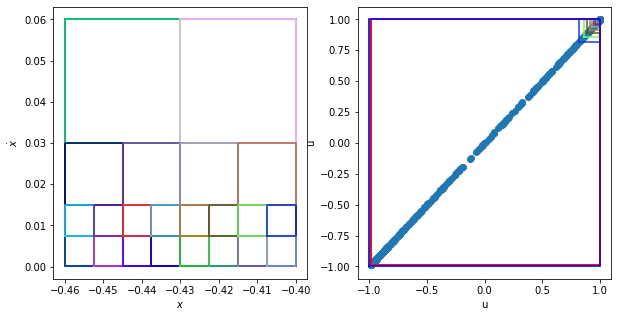

In [141]:
model = keras.models.load_model("../ddpg/models/car_actor.tf")
state_interval = Interval(interval = [(-0.46, -0.40), (0.0, 0.06)])
low, high = state_interval.high_low()
print(low,high)
H = np.concatenate([np.random.uniform(low[0], high[0], 5000).reshape(5000,1), np.random.uniform(low[1], high[1], 5000).reshape(5000,1)], axis=1)
action_interval, ax_input, ax_output = reachMLP(model, H, 0.01, 5000, input_y=1, output_y=0)

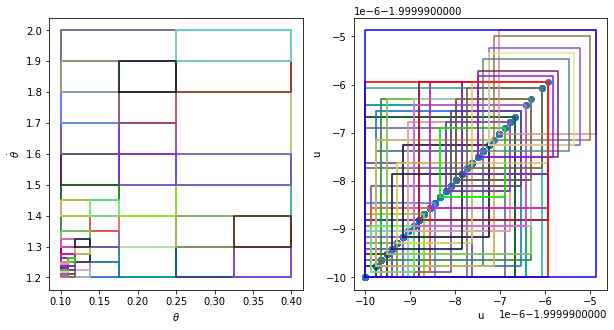

In [144]:
model = keras.models.load_model("../ddpg/models/pendulum_actor.tf")
state_interval = Interval(interval = [(0.1, 0.4), (1.2,2)])
low, high = state_interval.high_low()
theta = np.random.uniform(low[0], high[0], 10000).reshape(10000,1)
# print(theta)
# print(np.cos(theta).shape)
# print(np.cos(theta), np.sin(theta))
H = np.concatenate([np.cos(theta), np.sin(theta), np.random.uniform(low[1], high[1], 10000).reshape(10000,1)], axis=1)
ue = reachMLP_pendulum(model, H, state_interval, 0.01, 10000, input_y=1, output_y=0)

<AxesSubplot:>

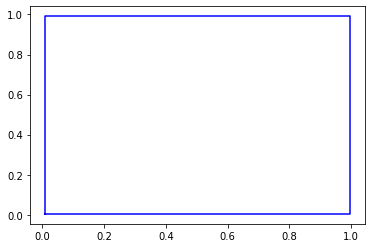

In [18]:
eta1 = create_interval(np.random.random(size=(100, 8)))
eta2 = create_interval(np.random.random(size=(100, 8)))
plot_interval(eta1, 0, 1)

In [19]:
model = keras.models.load_model("../ddpg/models/pendulum_actor.tf")

In [20]:
model.layers[len(model.layers)-1](np.array(([1, 2, 3, 4])))

TypeError: Exception encountered when calling layer "lambda" (type Lambda).

Cannot convert [2.0] to EagerTensor of dtype int32

Call arguments received:
  • inputs=tf.Tensor(shape=(4,), dtype=int32)
  • mask=None
  • training=None